## Imports

In [1]:
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import inception_resnet_v2
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle

## Load Data

In [2]:
# Data from google colab
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#Import from local repository

data = image_dataset_from_directory("/Users/cristobalmorano/code/nadiasalmen/waiste/waiste/data", 
                             labels='inferred', label_mode='categorical', class_names=None, color_mode='rgb',
                             batch_size=32, image_size=(128, 128), shuffle=True, seed=None,
                             validation_split=None, subset=None, interpolation='bilinear', follow_links=False,
                             crop_to_aspect_ratio=False)

Found 22610 files belonging to 10 classes.


2021-10-01 08:20:41.172747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Take number of images according to batch size

data_sample = data.take(250)

data_im = []
data_lb = []

for im, lb in data_sample:
    data_im.append(im)
    data_lb.append(lb)

2021-10-01 08:20:41.238185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
#Normalize image tensors (0 - 1)

def norma_2(image):
    image = tf.cast(image/255, tf.float32)
    return image

data_im_2 = [norma_2(image) for image in data_im]

In [6]:
#Convert X and y to numpy arrays

data_im_2 = np.array(data_im_2)
data_lb = np.array(data_lb)

In [7]:
#Reshape for model

data_im_2 = data_im_2.reshape(-1, 128, 128, 3)
data_lb = data_lb.reshape(-1, 10)

In [8]:
# Split the data

train_X, test_X, train_y, test_y = train_test_split(data_im_2, data_lb, test_size=0.2, random_state=42)

## Build model

In [9]:
#Import InceptionResNetV2

inception_resnet_v2 = inception_resnet_v2.InceptionResNetV2(include_top=False, 
                                                            weights="imagenet", input_tensor=None, 
                                                            input_shape=(128, 128, 3), pooling=None, 
                                                            classifier_activation='softmax')

In [10]:
inception_resnet_v2.trainable = False

In [11]:
def init_model():
    model = Sequential()
    
    model.add(inception_resnet_v2)
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)))
    model.add(MaxPooling2D(pool_size=2), padding = "same")
    model.add(Dropout(0.3))   
    
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2), padding = "same")
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, padding = "same"))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [12]:
model = init_model()

TypeError: add() got an unexpected keyword argument 'padding'

In [ ]:
model.summary()

In [46]:
es = EarlyStopping(patience = 20, monitor='val_loss' , min_delta=0.001, restore_best_weights = True)

In [47]:
history = model.fit(train_X, train_y, validation_split = 0.3, 
                    callbacks = [es], batch_size = 64, 
                    epochs = 500, verbose = 1)

Epoch 1/500
20/20 [==============================] - 67s 3s/step - loss: 2.2881 - accuracy: 0.1611 - val_loss: 2.1055 - val_accuracy: 0.3086
Epoch 2/500
20/20 [==============================] - 53s 3s/step - loss: 2.0999 - accuracy: 0.2185 - val_loss: 1.9789 - val_accuracy: 0.3699
Epoch 3/500
20/20 [==============================] - 53s 3s/step - loss: 1.9417 - accuracy: 0.3054 - val_loss: 1.8206 - val_accuracy: 0.4665
Epoch 4/500
20/20 [==============================] - 87s 4s/step - loss: 1.8065 - accuracy: 0.3724 - val_loss: 1.6978 - val_accuracy: 0.4647
Epoch 5/500
20/20 [==============================] - 63s 3s/step - loss: 1.6768 - accuracy: 0.4219 - val_loss: 1.5341 - val_accuracy: 0.5093
Epoch 6/500
20/20 [==============================] - 60s 3s/step - loss: 1.5037 - accuracy: 0.4936 - val_loss: 1.3883 - val_accuracy: 0.5874
Epoch 7/500
20/20 [==============================] - 57s 3s/step - loss: 1.3979 - accuracy: 0.5263 - val_loss: 1.3681 - val_accuracy: 0.5967
Epoch 8/500
2

In [48]:
def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10, 15))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()

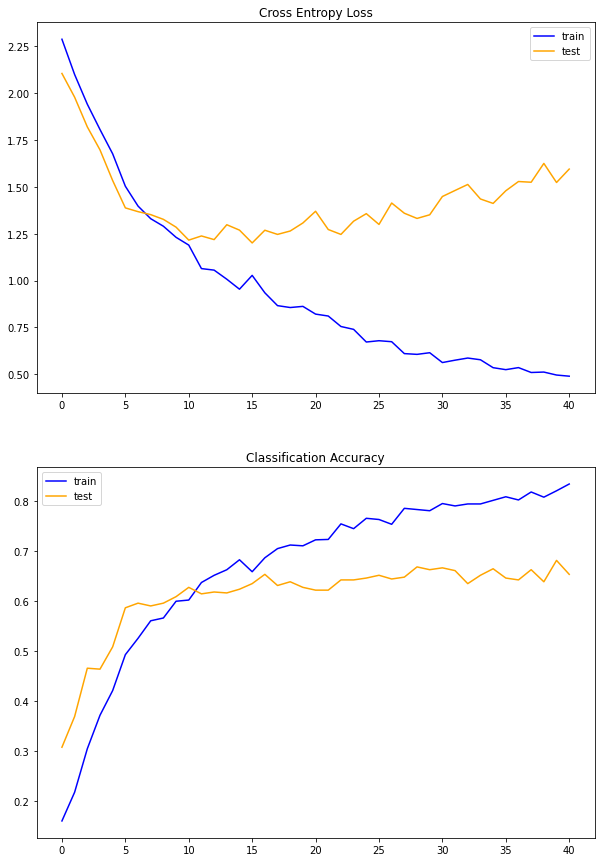

In [49]:
summarize_diagnostics(history)

In [50]:
scores = model.evaluate(test_X, test_y, verbose=1)

14/14 [==============================] - 16s 910ms/step - loss: 1.2130 - accuracy: 0.6339


In [51]:
tf.keras.models.save_model(
    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

NameError: name 'filepath' is not defined